Exercise 1

1. Load the CIFAR-10 dataset

2. Implement a CNN model (e.g. 5 conv layers) with <=100 features on output

3. Train the discriminator using triplet loss

4. Save the weights of trained discriminator model

5. Build a model for classification of CIFAR-10, starting with the layers from discriminator and one or two fully-connected layers after that

6. Train this model in the following scenarios and compare results:

a. Randomly initialized model

b. Model with weights for convolutional layers loaded from trained discriminator, fully-connected layers initialized randomly

c. Model with weights for convolutional layers loaded from trained discriminator and freezed, fully-connected layers initialized randomly

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [4]:
x_train.shape

(50000, 32, 32, 3)

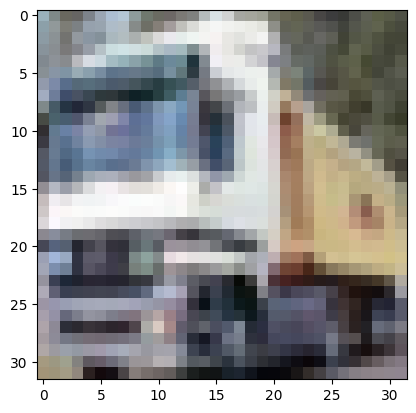

In [19]:
plt.imshow(x_train[1])

C:\Users\akopa\AppData\Local\Temp\ipykernel_14936\1710894633.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


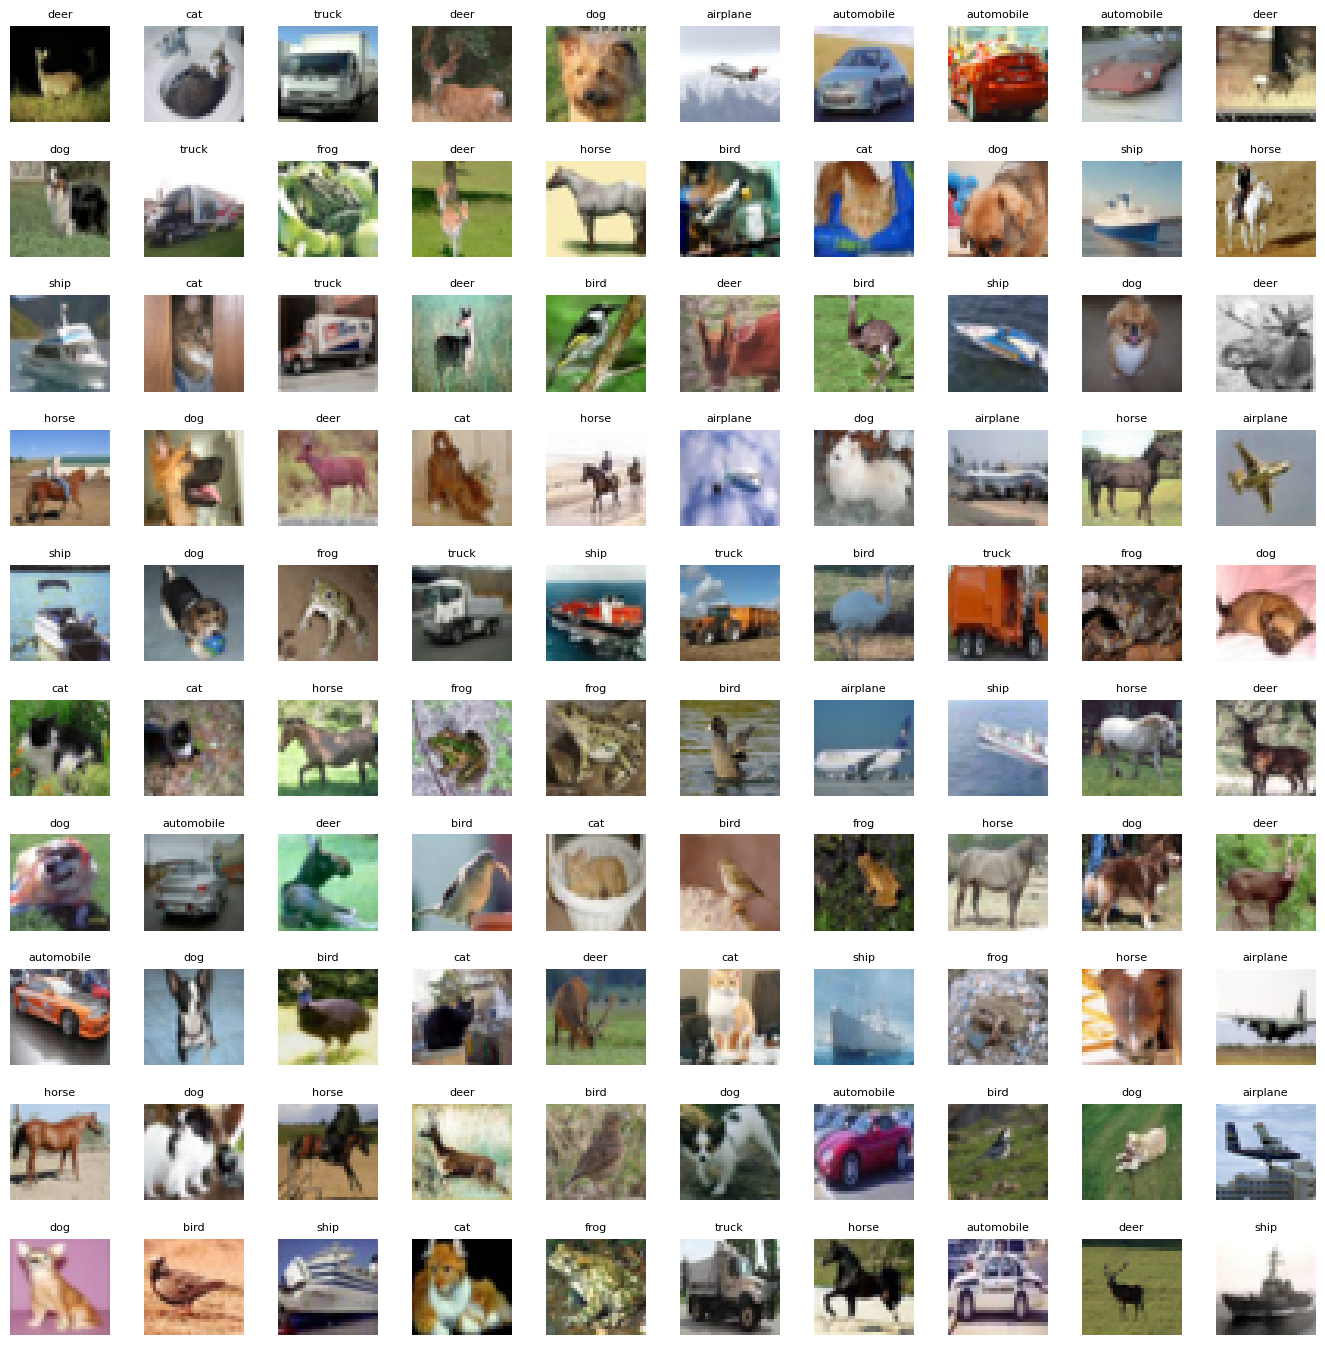

In [20]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot return the figure object and axes object
# we can use the axes object to plot specific figures at various locations

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(x_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [17]:
x_train.shape

(50000, 32, 32, 3)

In [13]:
from torch.nn import TripletMarginLoss